* best validation loss : 0.5262180339206349(img size=256, all fc to 1\*1 conv, nn.upsample)
  * 0.546918155930259(img size=224)
  * worse than above(no input normalization)
  * 0.5481791387904774(lower lr=5e-6)

In [9]:
import os 

import torch
from torch import nn
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import vgg16, VGG16_Weights

from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from torchsummary import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

In [10]:
class ToNumpy(object):
    def __call__(self, image):
        self.image = image
        self.image = np.array(self.image)
        return torch.tensor(self.image)
    
class NoVoid(object):
    def __call__(self, tensor):
        return torch.where(tensor==255, 0, tensor)
    
# class OneHot(object):
#     def __call__(self, tensor):
#         shape = tensor.shape
#         tensor = tensor.to(torch.int64)
#         # one hot : (B, C=num_classes, H, W)
#         one_hot = torch.zeros((shape[0], 21) + shape[1:])
        
#         # labels : (B, H, W)
#         # labels.unsqueeze(1) : (B, C=1, H, W)
#         # ret : (B, C=num_classes, H, W)
#         ret = one_hot.scatter_(1, tensor.unsqueeze(1), 1.0)
#         return ret.transpose(0, 1)



In [11]:
image_size = (256, 256)
transform1 = Compose([Resize(image_size), ToTensor(), Normalize(mean=[0.4538, 0.4416, 0.4077], std=[0.2631, 0.2597, 0.2765])])
transform2 = Compose([Resize(image_size), ToTensor(), Normalize(mean=[0.4563, 0.4381, 0.3995], std=[0.2614, 0.2595, 0.2757])])
target_transform = Compose([Resize(image_size),ToNumpy(), NoVoid()])

In [12]:
class_dict = {0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car" , 8:"cat", 9:"chair", 10:"cow", 11:"diningtable", 12:"dog", 13:"horse", 14:"motorbike", 15:"person", 16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor"}

In [13]:
ds = VOCSegmentation("./data", year="2011", image_set="train", download=False, transform=transform1, target_transform=target_transform)
ds_val = VOCSegmentation("./data_val", year="2011", image_set="val", download=False, transform=transform2, target_transform=target_transform)

In [14]:
# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in loader:
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std

In [15]:
ds[0][0].shape

torch.Size([3, 256, 256])

In [16]:
ds[0][1].shape

torch.Size([256, 256])

In [17]:
fcn_vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

def new_forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.classifier(x)
    return x

bound_method = new_forward.__get__(fcn_vgg16, fcn_vgg16.__class__)
setattr(fcn_vgg16, 'forward', bound_method)

# fcn_vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))

fcn_vgg16.classifier = nn.Sequential(
    nn.Conv2d(512, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 4096, (1, 1)),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(4096, 21, (1, 1)),
    nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)
    # nn.ConvTranspose2d(21, 21, (32, 32), stride=32, bias=False)
)

for name, module in fcn_vgg16.classifier.named_modules():
    if name == '6':
        module.weight.data.zero_()


In [18]:
summary(fcn_vgg16, (3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [19]:
train_dataloader = DataLoader(ds, batch_size=20, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(ds_val, batch_size=20, shuffle=True, drop_last=True)

In [28]:
train_losslist = []
val_losslist = []
device = "cuda"
fcn_vgg16.to(device)
# optimizer = SGD(fcn_vgg16.parameters(), 1e-4, momentum=0.9, weight_decay=5**-4)
optimizer = Adam(fcn_vgg16.parameters(), lr=1e-5)
epochs = 200
loss = nn.CrossEntropyLoss()

patience = 20
earlystop_counter = 0
best_loss = np.inf

epoch_start = 1

checkpoint = torch.load('saved/checkpoint_model_15.pt')
epoch_start=checkpoint['epoch']
fcn_vgg16.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_losslist = checkpoint['train_loss']
val_losslist = checkpoint['val_loss']
best_loss = checkpoint['earlystop']['bestloss']

for i in range(epoch_start, epochs+1):
    print("-----------------------------")
    print(f"epoch {i}")
    fcn_vgg16.train()
    loss_sum = 0
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        X = X.to(device)
        y = y.to(device).long()
        pred = fcn_vgg16(X)
        loss_out = loss(pred, y)
        
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
        loss_sum += loss_out.item()
    train_losslist.append(loss_sum/len(train_dataloader))
    print(f"total loss : {loss_sum/len(train_dataloader)}")
    
    fcn_vgg16.eval()
    loss_sum = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(valid_dataloader)):
            X = X.to(device)
            y = y.to(device).long()
            pred = fcn_vgg16(X)
            loss_sum += loss(pred, y).item()
        val_loss = loss_sum/len(valid_dataloader)
        val_losslist.append(val_loss)
        print(f"val loss : {val_loss}")
        
        if best_loss > val_loss:
            print(f"validation loss imporved : {best_loss} -> {val_loss}")
            best_loss = val_loss
            earlystop_counter = 0
            torch.save(fcn_vgg16.state_dict(), "best.pt")
        else:
            earlystop_counter+=1
        
        if earlystop_counter == patience:
            print(f"No validation improvement until {earlystop_counter} epoch. Terminating training loop.")
            best = torch.load("best.pt")
            fcn_vgg16.load_state_dict(best)
            break
        
    torch.save({
        'epoch': i,
        'model_state_dict': fcn_vgg16.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losslist,
        'val_loss': val_losslist,
        'earlystop': {'patience': patience, 'counter': earlystop_counter, 'bestloss': best_loss}
    }, os.path.normpath(f"saved/checkpoint_model_{i}.pt"))
    
    try:
        os.remove(os.path.normpath(f"saved/checkpoint_model_{i-1}.pt"))
    except OSError:
        pass

    print("")
            
            
        

-----------------------------
epoch 15


100%|██████████| 55/55 [02:32<00:00,  2.77s/it]


total loss : 0.4265011928298257


100%|██████████| 55/55 [01:17<00:00,  1.41s/it]


val loss : 0.6504015619104558

-----------------------------
epoch 16


100%|██████████| 55/55 [06:10<00:00,  6.74s/it]


total loss : 0.412486976926977


100%|██████████| 55/55 [01:59<00:00,  2.16s/it]


val loss : 0.5700836577198722
validation loss imporved : 0.6160366556861184 -> 0.5700836577198722

-----------------------------
epoch 17


100%|██████████| 55/55 [06:17<00:00,  6.87s/it]


total loss : 0.3970333229411732


100%|██████████| 55/55 [04:56<00:00,  5.39s/it]


val loss : 0.6076899626038291

-----------------------------
epoch 18


100%|██████████| 55/55 [02:41<00:00,  2.94s/it]


total loss : 0.38888871723955326


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


val loss : 0.6240051204508001

-----------------------------
epoch 19


100%|██████████| 55/55 [08:08<00:00,  8.88s/it]


total loss : 0.37463878393173217


100%|██████████| 55/55 [04:47<00:00,  5.22s/it]


val loss : 0.5782311076467688

-----------------------------
epoch 20


100%|██████████| 55/55 [02:38<00:00,  2.89s/it]


total loss : 0.36624047539450905


100%|██████████| 55/55 [00:44<00:00,  1.25it/s]


val loss : 0.606849832426418

-----------------------------
epoch 21


100%|██████████| 55/55 [02:24<00:00,  2.63s/it]


total loss : 0.3563318599354137


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


val loss : 0.5871468088843605

-----------------------------
epoch 22


100%|██████████| 55/55 [02:04<00:00,  2.27s/it]


total loss : 0.344744782556187


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


val loss : 0.5812135073271665

-----------------------------
epoch 23


100%|██████████| 55/55 [01:57<00:00,  2.13s/it]


total loss : 0.33150714446197854


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


val loss : 0.5939842354167592

-----------------------------
epoch 24


100%|██████████| 55/55 [02:02<00:00,  2.23s/it]


total loss : 0.3283940309827978


100%|██████████| 55/55 [00:42<00:00,  1.30it/s]


val loss : 0.5614690791476856
validation loss imporved : 0.5700836577198722 -> 0.5614690791476856

-----------------------------
epoch 25


100%|██████████| 55/55 [01:54<00:00,  2.08s/it]


total loss : 0.32167280424724926


100%|██████████| 55/55 [00:44<00:00,  1.23it/s]


val loss : 0.5481791387904774
validation loss imporved : 0.5614690791476856 -> 0.5481791387904774

-----------------------------
epoch 26


100%|██████████| 55/55 [02:02<00:00,  2.24s/it]


total loss : 0.3106096665967594


100%|██████████| 55/55 [00:43<00:00,  1.26it/s]


val loss : 0.5721005396409469

-----------------------------
epoch 27


100%|██████████| 55/55 [01:59<00:00,  2.18s/it]


total loss : 0.30341615080833434


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


val loss : 0.566602848334746

-----------------------------
epoch 28


100%|██████████| 55/55 [01:53<00:00,  2.07s/it]


total loss : 0.2944877191023393


100%|██████████| 55/55 [00:48<00:00,  1.14it/s]


val loss : 0.5692693536931818

-----------------------------
epoch 29


100%|██████████| 55/55 [01:56<00:00,  2.12s/it]


total loss : 0.28973482007330115


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


val loss : 0.5601408151063052

-----------------------------
epoch 30


100%|██████████| 55/55 [01:50<00:00,  2.01s/it]


total loss : 0.2808413874019276


100%|██████████| 55/55 [00:44<00:00,  1.24it/s]


val loss : 0.5600568126548421

-----------------------------
epoch 31


100%|██████████| 55/55 [01:55<00:00,  2.11s/it]


total loss : 0.2775705399838361


100%|██████████| 55/55 [00:45<00:00,  1.22it/s]


val loss : 0.597340604391965

-----------------------------
epoch 32


100%|██████████| 55/55 [01:56<00:00,  2.11s/it]


total loss : 0.2740032323382118


100%|██████████| 55/55 [00:43<00:00,  1.28it/s]


val loss : 0.5520050043409521

-----------------------------
epoch 33


100%|██████████| 55/55 [01:54<00:00,  2.08s/it]


total loss : 0.26270759132775395


100%|██████████| 55/55 [00:43<00:00,  1.26it/s]


val loss : 0.5820457144217057

-----------------------------
epoch 34


100%|██████████| 55/55 [01:57<00:00,  2.14s/it]


total loss : 0.2581559492783113


100%|██████████| 55/55 [00:41<00:00,  1.31it/s]


val loss : 0.5650892664085735

-----------------------------
epoch 35


100%|██████████| 55/55 [01:52<00:00,  2.05s/it]


total loss : 0.2525411145253615


100%|██████████| 55/55 [00:45<00:00,  1.20it/s]


val loss : 0.5560681440613486

-----------------------------
epoch 36


100%|██████████| 55/55 [01:56<00:00,  2.13s/it]


total loss : 0.24912031157450243


100%|██████████| 55/55 [00:43<00:00,  1.26it/s]


val loss : 0.5946659673344005

-----------------------------
epoch 37


100%|██████████| 55/55 [02:00<00:00,  2.19s/it]


total loss : 0.2436066378246654


100%|██████████| 55/55 [00:42<00:00,  1.31it/s]


val loss : 0.5723137546669353

-----------------------------
epoch 38


100%|██████████| 55/55 [01:54<00:00,  2.08s/it]


total loss : 0.23721041841940446


100%|██████████| 55/55 [00:44<00:00,  1.23it/s]


val loss : 0.5562627889893271

-----------------------------
epoch 39


100%|██████████| 55/55 [02:04<00:00,  2.26s/it]


total loss : 0.23136846748265352


100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


val loss : 0.5786594201217998

-----------------------------
epoch 40


100%|██████████| 55/55 [01:25<00:00,  1.55s/it]


total loss : 0.2299069716171785


100%|██████████| 55/55 [00:36<00:00,  1.49it/s]


val loss : 0.5834723987362601

-----------------------------
epoch 41


100%|██████████| 55/55 [01:30<00:00,  1.65s/it]


total loss : 0.22598563026298177


100%|██████████| 55/55 [00:36<00:00,  1.52it/s]


val loss : 0.5940146494995464

-----------------------------
epoch 42


100%|██████████| 55/55 [01:19<00:00,  1.44s/it]


total loss : 0.22052121270786632


100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


val loss : 0.5668349802494049

-----------------------------
epoch 43


100%|██████████| 55/55 [01:22<00:00,  1.50s/it]


total loss : 0.21628859801725908


100%|██████████| 55/55 [00:32<00:00,  1.71it/s]


val loss : 0.5857023575089194

-----------------------------
epoch 44


100%|██████████| 55/55 [01:34<00:00,  1.72s/it]


total loss : 0.21399366503412073


100%|██████████| 55/55 [00:35<00:00,  1.53it/s]


val loss : 0.5846673932942477

-----------------------------
epoch 45


100%|██████████| 55/55 [01:50<00:00,  2.01s/it]


total loss : 0.2094531695951115


100%|██████████| 55/55 [00:41<00:00,  1.33it/s]

val loss : 0.5857475074854764
No validation improvement until 20 epoch. Terminating training loop.


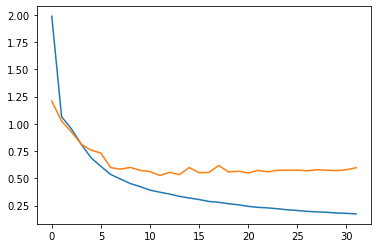

In [ ]:
plt.plot(train_losslist)
plt.plot(val_losslist)

In [ ]:
checkpoint = torch.load("best.pt")

In [ ]:
fcn_vgg16.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
fcn_vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
raw_light_palette = [
"#800080",
"#0F0F0F",
"#FF0000",
"#00FF00",
"#0000FF",
"#FFFF00",
"#00FFFF",
"#FF00FF",
"#FFA500",
"#A52A2A",
"#00FF7F",
"#FFC0CB",
"#008080",
"#E6E6FA",
"#800000",
"#808000",
"#FF7F50",
"#000080",
"#808080",
"#87CEEB",
"#F5F5DC"]

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
cm = ListedColormap(raw_light_palette)

dict_values(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


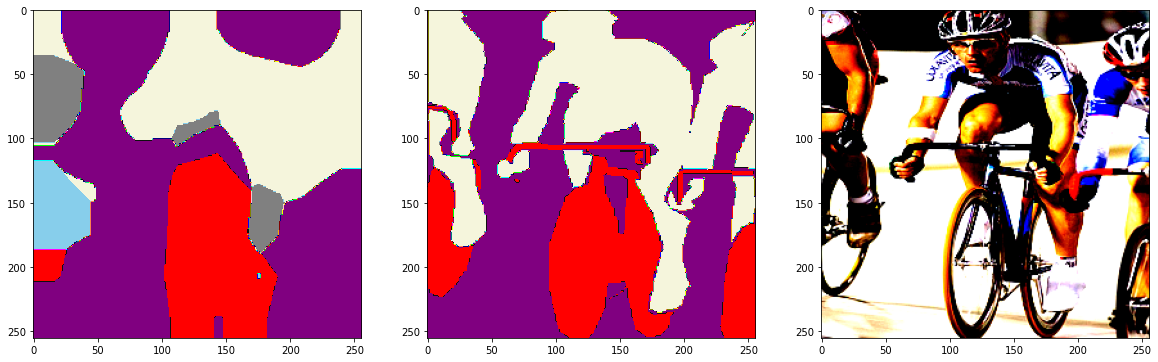

In [ ]:
image_idx = 4
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes = axes.flatten()

output = fcn_vgg16(ds_val[image_idx][0].unsqueeze(dim=0).to(device))
# plt.imshow(output[0].argmax(axis=0).cpu())

ax1 = axes[0].imshow(output[0].argmax(axis=0).cpu(), cmap=cm)
ax2 = axes[1].imshow(ds_val[image_idx][1], cmap=cm)
ax3 = axes[2].imshow(ds_val[image_idx][0].permute(1, 2, 0))

# fig.subplots_adjust(bottom=0.01)
# cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.05])
# cbar1 = plt.colorbar(ax1, orientation='horizontal')
# cbar1.set_ticks(np.array(range(21)) + .5)
# cbar1.ax.set_xticklabels(list(class_dict.values()))